In [2]:
!pip install --upgrade pip
!pip install imblearn
!pip install scikit-optimize

Looking in indexes: https://devpi.svc.ngsci.local/root/pypi/+simple/
Looking in indexes: https://devpi.svc.ngsci.local/root/pypi/+simple/
Looking in indexes: https://devpi.svc.ngsci.local/root/pypi/+simple/


In [1]:
# Import necessary libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import StandardScaler
from imblearn.metrics import specificity_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from scipy.optimize import minimize

#Import classifier libraries
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm

import itertools
import time
from skopt import gp_minimize
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical


In [2]:
# Function to evaluate the model
def evaluate_model(model, X, y):
    """
    Calculate Evluation metrics for a given model and dataset.
    
    Parameters:
    model : sklearn model
        The trained model used to predict the labels.
    X : array-like or DataFrame
        The input data used for prediction.
    y : array-like or Series
        The true labels of the data.
    
    Returns:
    accuracy : float
        The Accuracy of the model.
    precision or PPV : float
        The Accuracy Precision or PPV the model.
    recall : float
        The Recall of the model.
    specificity : float
        The Specificity of the model.
    f1-score : float
        The f1-score of the model.
    auc_roc : float
        The auc_roc of the model.
    npv : float
        The Negative Predictive Value (NPV) of the model.
    """
    y_pred = model.predict(X)
    #y_prob = model.predict_proba(X)[:, 1]  # Probability estimates for the positive class

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    specificity = specificity_score(y, y_pred)
    
    f1 = f1_score(y, y_pred)
    npv = calculate_npv(y, y_pred)

    return accuracy, precision, recall, specificity, npv, f1

# Plot the AUC-ROC curve for each set
def plot_roc_curve(model, X, y, set_name):
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) - ' + set_name)
    plt.legend(loc="lower right")
    plt.show()

    # Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, set_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {set_name}')
    plt.show()
    
def calculate_npv(y, y_pred):
    """
    Calculate the Negative Predictive Value (NPV) for a given model and dataset.
    
    Parameters:
    model : sklearn model
        The trained model used to predict the labels.
    X : array-like or DataFrame
        The input data used for prediction.
    y : array-like or Series
        The true labels of the data.
    
    Returns:
    npv : float
        The Negative Predictive Value (NPV) of the model.
    """
    
    # Generate the confusion matrix
    tn, fp, fn, tp = confusion_matrix(y, y_pred).ravel()
    
    # Calculate NPV
    npv = tn / (tn + fn)
    
    return npv 

def show_model_eval(model, X, y, data_type):
    metrics = evaluate_model(model, X, y)
    print("\n ",data_type, " Metrics:")
    print("Accuracy: {:.2f}".format(metrics[0]))
    print("Precision: {:.2f}".format(metrics[1]))
    print("Recall: {:.2f}".format(metrics[2]))
    print("Specificity: {:.2f}".format(metrics[3]))
    print("Negative Predictive Value: {:.2f}".format(metrics[4]))
    print("F1-Score: {:.2f}".format(metrics[5]))
    
    #Plot Confusion Matrix
    y_pred = model.predict(X)
    plot_confusion_matrix(y, y_pred, data_type)

def print_train_val_metrics(metrics_train, metrics_val):
    print("Train Set Metrics")
    print("Accuracy: {:.2f}".format(metrics_train[0]))
    print("Precision: {:.2f}".format(metrics_train[1]))
    print("Recall: {:.2f}".format(metrics_train[2]))
    print("Specificity: {:.2f}".format(metrics_train[3]))
    print("Negative Predictive Value: {:.2f}".format(metrics_train[4]))
    print("F1-Score: {:.2f}".format(metrics_train[5]))

    print("\nValidation Set Metrics:")
    print("Accuracy: {:.2f}".format(metrics_val[0]))
    print("Precision: {:.2f}".format(metrics_val[1]))
    print("Recall: {:.2f}".format(metrics_val[2]))
    print("Specificity: {:.2f}".format(metrics_val[3]))
    print("Negative Predictive Value: {:.2f}".format(metrics_val[4]))
    print("F1-Score: {:.2f}".format(metrics_val[5]))
    
def print_cv_metrics(model,X,y,cv):
    metrics = ['accuracy', 'precision', 'recall', 'f1']

    #caculate the metrics using cross validation
    for metric in metrics:
        score = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
        print(metric, ': mean %.3f and standard deviation (%.3f)' % (np.mean(score), np.std(score)))

    #find the specificity
    specificity = cross_val_score(model, X, y, scoring=make_scorer(recall_score, pos_label=0))
    print('specificity: mean %.3f and standard deviation (%.3f)' % (np.mean(specificity), np.std(specificity)))

    #find the npv
    npvs = cross_val_score(model, X, y, scoring=make_scorer(precision_score, pos_label=0))
    print('npv: mean %.3f and standard deviation (%.3f)' % (np.mean(npvs), np.std(npvs)))
    


In [3]:
#Read data
filter_dir = os.path.join('/','home','ngsci','project','csv_files_and_genarators')
data_positive_label = pd.read_csv(os.path.join(filter_dir,'data_OHCA_preECGs_w24h.csv'))
data_negative_label = pd.read_csv(os.path.join(filter_dir,'data_ctrg_preECGs_wNdays.csv'))

print(data_positive_label.shape)
print(data_negative_label.shape)

#Concatanete both datasets
dataset_df = pd.concat([data_negative_label,data_positive_label], ignore_index=True)

#Remove IDs
dataset_df = dataset_df.drop(columns=['ecg_id', 'patient_id'])


(19, 26)
(247, 26)


In [4]:
#Apply SMOTE to minority class
X = dataset_df.drop('label', axis=1)  # Features
y = dataset_df['label']  # Labels

# Count the current number of labels
count_label_1 = sum(y == 1)

# Initialize SMOTE with the desired ratio
resampling_factor=3
smote = SMOTE(sampling_strategy={1: count_label_1*resampling_factor}, random_state=42)

# Apply SMOTE
X_resampled, y_resampled = smote.fit_resample(X, y)

#Standarize the dataset
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Create a new dataframe with the resampled data
resampled_df = pd.concat([pd.DataFrame(X_scaled, columns=X.columns), pd.DataFrame(y_resampled, columns=['label'])], axis=1)

print("Original dataset shape:", dataset_df.shape)
print("Resampled dataset shape:", resampled_df.shape)
print("Original class distribution:\n", dataset_df['label'].value_counts())
print("Resampled class distribution:\n", resampled_df['label'].value_counts())

Original dataset shape: (266, 24)
Resampled dataset shape: (304, 24)
Original class distribution:
 label
0    247
1     19
Name: count, dtype: int64
Resampled class distribution:
 label
0    247
1     57
Name: count, dtype: int64


In [5]:
# Split the dataset into training, validation, and testing sets
train_df, val_df = train_test_split(resampled_df, test_size=0.3, random_state=42)

# Define the features (X) and target (y)
X_train = train_df.drop('label', axis=1)
y_train = train_df['label']
X_val = val_df.drop('label', axis=1)
y_val = val_df['label']

In [6]:
# Initialize the models.
#Decision Tree
#dt = DecisionTreeClassifier(max_depth=7, max_features=0.5, max_leaf_nodes=10, random_state=42)
dt = DecisionTreeClassifier(max_depth=5, max_features=0.5, max_leaf_nodes=7,
                       random_state=42) #New
#SVM
#svm_nL = svm.SVC(C=0.5, class_weight='balanced', probability=True, random_state=1, tol=0.1)
svm_nL = svm.SVC(class_weight='balanced', gamma=0.1, probability=True, random_state=1) #New

#KNN 
#knn = KNeighborsClassifier(n_neighbors=4, weights='distance')
knn = KNeighborsClassifier(n_neighbors=4, weights='distance') #New

#Stocastic Gradient Descent Classifier (SGDC) 
#sgdc = SGDClassifier(alpha=0.001, class_weight='balanced', l1_ratio=0.0,
#                          loss='perceptron', penalty=None, random_state=42)
sgdc = SGDClassifier(alpha=0.01, class_weight='balanced', early_stopping=True,
              l1_ratio=0.1, penalty='elasticnet', loss='modified_huber', 
              random_state=42) #New

#Logistic Regression
#lr = LogisticRegression(C=0.55, class_weight='balanced', intercept_scaling=3.0,
#                               multi_class='ovr', penalty='l1', random_state=42,
#                               solver='liblinear', tol=0.055)

lr = LogisticRegression(C=0.775, class_weight='balanced', intercept_scaling=2.5,
                   multi_class='ovr', penalty='l1', random_state=42,
                   solver='liblinear', tol=0.01) #New

#Define the cross validation strategy
outer_folds = 5
cv_outer = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)

Train Set Metrics
Accuracy: 0.99
Precision: 0.97
Recall: 0.95
Specificity: 0.99
Negative Predictive Value: 0.99
F1-Score: 0.96

Validation Set Metrics:
Accuracy: 0.87
Precision: 0.67
Recall: 0.59
Specificity: 0.93
Negative Predictive Value: 0.91
F1-Score: 0.62


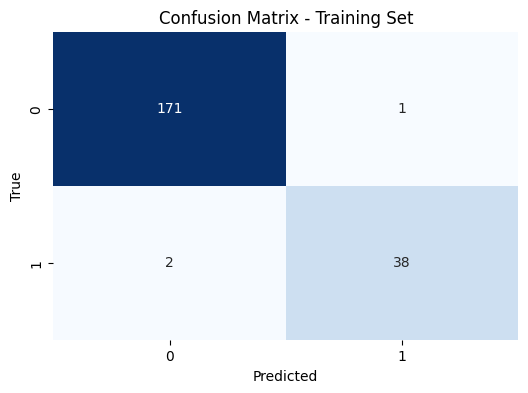

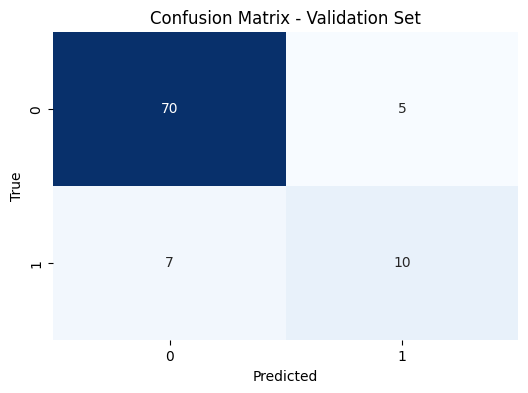

In [7]:
#Define estimators
models=[('dt',dt), 
        ('svm',svm_nL), 
        ('knn',knn), 
        ('sgdc',sgdc), 
        ('lr', lr)]

# Initialize the voting classifier
model = VotingClassifier(estimators=models, voting='soft', 
                         flatten_transform=True)

model.fit(X_train, y_train)

# Evaluate the model on training, validation, and test sets
metrics_train = evaluate_model(model, X_train, y_train)
metrics_val = evaluate_model(model, X_val, y_val)

# Print the metrics
print_train_val_metrics(metrics_train, metrics_val)
    
#Plot Confusion Matrix Training Set
y_train_pred = model.predict(X_train)
plot_confusion_matrix(y_train, y_train_pred, 'Training Set')

#Plot Confusion Matrix Validation Set
y_val_pred = model.predict(X_val)
plot_confusion_matrix(y_val, y_val_pred, 'Validation Set')


In [10]:
#Double checking with GridSearch
start = time.perf_counter()

space = dict()
# Generate all combinations of 5 integeres from 0 to 5
space['weights'] = list(itertools.product(range(3), repeat=5))

search = GridSearchCV(model, space, scoring='f1', n_jobs=1, cv=cv_outer, refit=True)

#scores = cross_val_score(search, X_scaled, y_resampled, scoring='f1', cv=cv_outer, n_jobs=-1)
#print(scores)
best_model = search.fit(X_scaled, y_resampled).best_estimator_

best_model.fit(X_scaled, y_resampled)

end = time.perf_counter()
print(f"Time taken: {(end - start)/60:.3f} minutes")

/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 234, in __call__
    return self._score(
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 276, in _score
    y_pred = method_caller(estimator, "predict", X)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/metrics/_scorer.py", line 73, in _cached_call
    return getattr(estimator, method)(*args, **kwargs)
  File "/opt/venv/default/lib/python3.10/site-packages/sklearn/ensemble/_voting.py", line 363, in predict
    maj = np.argmax(self.predict_pro

Time taken: 4.664 minutes


/opt/venv/default/lib/python3.10/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [       nan 0.63279263 0.63279263 0.54774084 0.57333333 0.64114286
 0.54774084 0.56401012 0.57333333 0.83541154 0.81861642 0.72955655
 0.70931069 0.65371675 0.65864286 0.56745098 0.57655914 0.62758108
 0.83541154 0.83007115 0.81861642 0.80395164 0.76382282 0.71333904
 0.70931069 0.64977586 0.65371675 0.89972294 0.88154113 0.79331081
 0.59693574 0.66245238 0.66234574 0.56745098 0.58090697 0.65447619
 0.87201732 0.88154113 0.8561581  0.82252174 0.83096237 0.71304348
 0.59325758 0.64800246 0.67292857 0.86344589 0.87201732 0.86249351
 0.81797628 0.82948599 0.81492455 0.79172753 0.77448949 0.71764118
 0.89972294 0.87011255 0.88154113 0.85640655 0.85116172 0.77512899
 0.59693574 0.66171978 0.66245238 0.87790476 0.87028571 0.88154113
 0.85640655 0.85640655 0.83572428 0.79491327 0.80441558 0.72785829
 0.87201732 0.86162771 0.88154113 0.86497798 0.84

In [11]:
best_model.weights

(0, 1, 0, 0, 0)

In [12]:
best_model=VotingClassifier(estimators=models, voting='soft', weights=best_model.weights, 
                         flatten_transform=True)

#print(best_model)
metrics = ['accuracy', 'precision', 'recall', 'f1']

#caculate the metrics using cross validation
for metric in metrics:
    score = cross_val_score(best_model, X_scaled, y_resampled, scoring=metric, cv=cv_outer, n_jobs=-1)
    print(metric, ': mean %.3f and standard deviation (%.3f)' % (np.mean(score), np.std(score)))

#find the specificity
specificity = cross_val_score(best_model, X_scaled, y_resampled, scoring=make_scorer(recall_score, pos_label=0))
print('specificity: mean %.3f and standard deviation (%.3f)' % (np.mean(specificity), np.std(specificity)))

#find the npv
npvs = cross_val_score(best_model, X_scaled, y_resampled, scoring=make_scorer(precision_score, pos_label=0))
print('npv: mean %.3f and standard deviation (%.3f)' % (np.mean(npvs), np.std(npvs)))

accuracy : mean 0.964 and standard deviation (0.012)
precision : mean 0.951 and standard deviation (0.063)
recall : mean 0.861 and standard deviation (0.066)
f1 : mean 0.900 and standard deviation (0.032)
specificity: mean 0.984 and standard deviation (0.024)
npv: mean 0.974 and standard deviation (0.032)


In [8]:
# Optimize using Bayesian for a Gaussian Process
# Objective function for Scikit-optimize

start = time.perf_counter()
def objective(weights):
    voting = VotingClassifier(estimators=models, voting='soft', weights=weights)
    score = cross_val_score(voting, X_scaled, y_resampled, cv=5, scoring='f1').mean()
    return -score  # Minimize negative score means maximize

# Define the search space
space = [Integer(0, 5) for _ in range(len(models))]

# Optimize the weights
result = gp_minimize(objective, space, n_calls=50, random_state=42)

# Best weights
best_weights = result.x
print("Best weights:", " ".join([f"{weight:.3f}" for weight in best_weights]))
#print(f'Best weights: {best_weights[0]:.3f} {best_weights[1]:.3f} {best_weights[2]:.3f} {best_weights[3]:.3f} {best_weights[4]:.3f}')

# Train the final model with the best weights
best_voting = VotingClassifier(estimators=models, voting='soft', weights=best_weights)
best_voting.fit(X_scaled, y_resampled)

#Calculate time taken
end = time.perf_counter()
print(f"Time taken: {(end - start)/60:.3f} minutes")

# Evaluate the best model found
print_cv_metrics(best_voting, X_scaled, y_resampled, cv_outer)

Best weights: 2.000 4.000 2.000 0.000 0.000
Time taken: 2.745 minutes
accuracy : mean 0.957 and standard deviation (0.030)
precision : mean 0.928 and standard deviation (0.063)
recall : mean 0.845 and standard deviation (0.143)
f1 : mean 0.878 and standard deviation (0.094)
specificity: mean 0.984 and standard deviation (0.024)
npv: mean 0.981 and standard deviation (0.024)


In [9]:
# Optimize using Bayesian for a Gaussian Process
# Objective function for Scikit-optimize

start = time.perf_counter()
def objective(weights):
    voting = VotingClassifier(estimators=models, voting='soft', weights=weights)
    score = cross_val_score(voting, X_scaled, y_resampled, cv=5, scoring='f1').mean()
    return -score  # Minimize negative score means maximize

# Define the search space
space = [Real(0, 5) for _ in range(len(models))]

# Optimize the weights
result = gp_minimize(objective, space, n_calls=50, random_state=42)

# Best weights
best_weights = result.x
print("Best weights:", " ".join([f"{weight:.3f}" for weight in best_weights]))
#print(f'Best weights: {best_weights[0]:.3f} {best_weights[1]:.3f} {best_weights[2]:.3f} {best_weights[3]:.3f} {best_weights[4]:.3f}')

# Train the final model with the best weights
best_voting = VotingClassifier(estimators=models, voting='soft', weights=best_weights)
best_voting.fit(X_scaled, y_resampled)

#Calculate time taken
end = time.perf_counter()
print(f"Time taken: {(end - start)/60:.3f} minutes")

# Evaluate the best model found
print_cv_metrics(best_voting, X_scaled, y_resampled, cv_outer)

Best weights: 2.581 5.000 1.518 0.000 0.000
Time taken: 2.636 minutes
accuracy : mean 0.957 and standard deviation (0.022)
precision : mean 0.938 and standard deviation (0.075)
recall : mean 0.845 and standard deviation (0.143)
f1 : mean 0.877 and standard deviation (0.074)
specificity: mean 0.984 and standard deviation (0.024)
npv: mean 0.981 and standard deviation (0.024)


# END

In [14]:
list(itertools.product(range(3), repeat=5))
space

[Integer(low=0, high=5, prior='uniform', transform='normalize'),
 Integer(low=0, high=5, prior='uniform', transform='normalize'),
 Integer(low=0, high=5, prior='uniform', transform='normalize'),
 Integer(low=0, high=5, prior='uniform', transform='normalize'),
 Integer(low=0, high=5, prior='uniform', transform='normalize')]